### Test of stationarity

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf

In [2]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
#     rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = timeseries.rolling(window=12,center=False).mean()
#     rolstd = pd.rolling_std(timeseries, window=12)
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='BIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [3]:
datasets = pd.read_excel('TB_nation.xlsx',index_col='Date')
datasets_pred = datasets[datasets.index>='2014-01-1']
datasets = datasets[datasets.index<'2014-01-01']
datasets.shape

(120, 7)

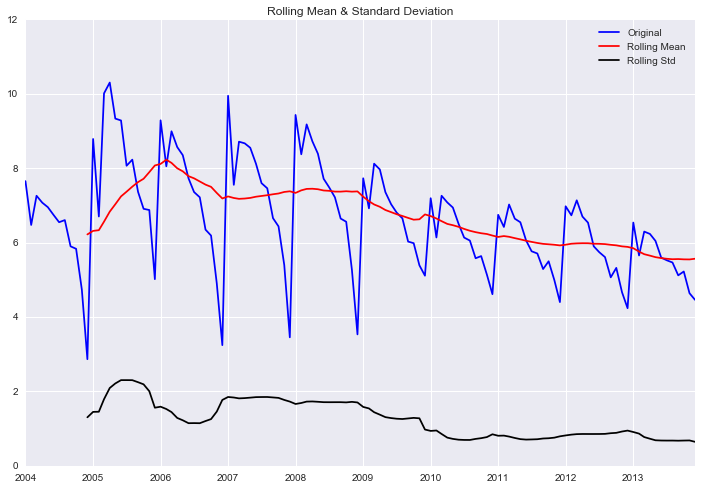

Results of Dickey-Fuller Test:
Test Statistic                  -0.851396
p-value                          0.803557
#Lags Used                      12.000000
Number of Observations Used    107.000000
Critical Value (10%)            -2.581393
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
dtype: float64


In [4]:
test_stationarity(datasets.Incidence_rate)

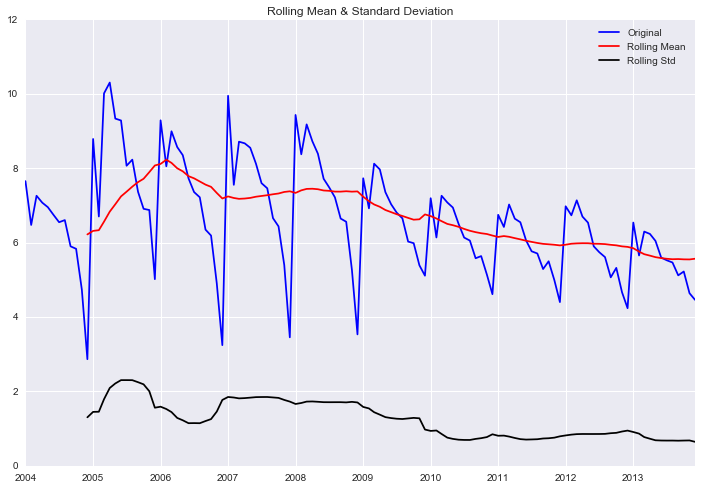

Results of Dickey-Fuller Test:
Test Statistic                  -0.851396
p-value                          0.803557
#Lags Used                      12.000000
Number of Observations Used    107.000000
Critical Value (10%)            -2.581393
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
dtype: float64


In [5]:
test_stationarity(datasets['Incidence_rate'])

### First difference

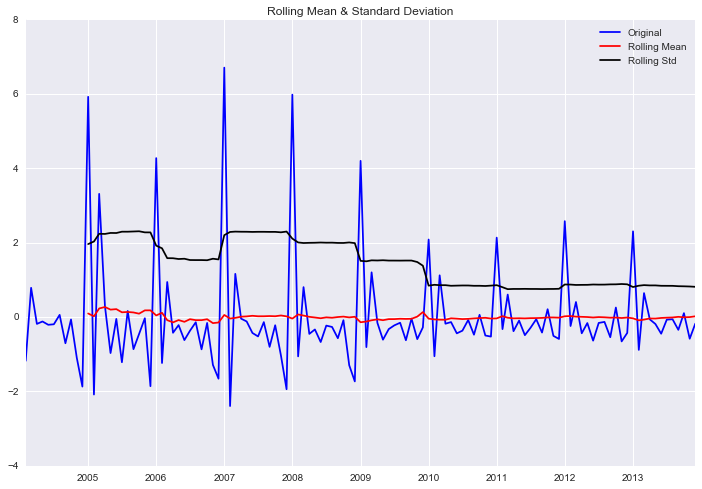

Results of Dickey-Fuller Test:
Test Statistic                  -3.789533
p-value                          0.003016
#Lags Used                      11.000000
Number of Observations Used    107.000000
Critical Value (10%)            -2.581393
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
dtype: float64


In [6]:
datasets['first_diff'] = datasets.Incidence_rate - datasets.Incidence_rate.shift(1)
test_stationarity(datasets.first_diff.dropna(inplace=False))

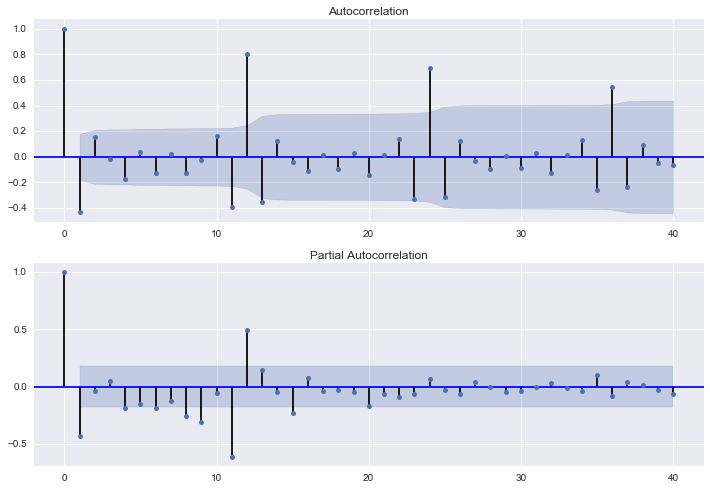

In [7]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(datasets.first_diff.iloc[1:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(datasets.first_diff.iloc[1:], lags=40, ax=ax2)

### Seasonal difference

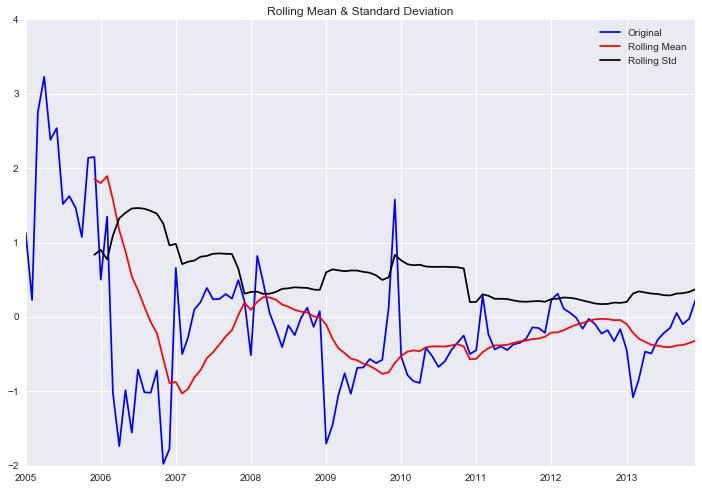

Results of Dickey-Fuller Test:
Test Statistic                  -4.078157
p-value                          0.001052
#Lags Used                       0.000000
Number of Observations Used    107.000000
Critical Value (10%)            -2.581393
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
dtype: float64


In [8]:
datasets['seasonal_difference'] = datasets.Incidence_rate - datasets.Incidence_rate.shift(12)  
test_stationarity(datasets.seasonal_difference.dropna(inplace=False))

### Seasonal first difference 

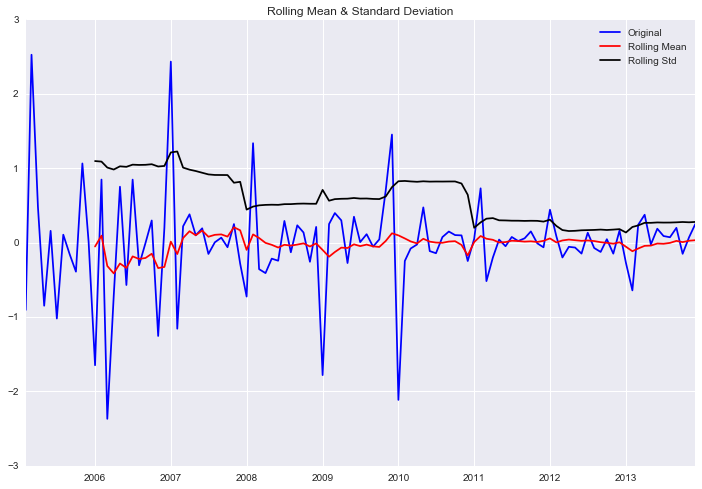

Results of Dickey-Fuller Test:
Test Statistic                -1.055529e+01
p-value                        7.981430e-19
#Lags Used                     1.000000e+00
Number of Observations Used    1.050000e+02
Critical Value (10%)          -2.581676e+00
Critical Value (1%)           -3.494220e+00
Critical Value (5%)           -2.889485e+00
dtype: float64


In [9]:
datasets['seasonal_first_difference'] = datasets.first_diff-datasets.first_diff.shift(12)
test_stationarity(datasets.seasonal_first_difference.dropna(inplace=False))

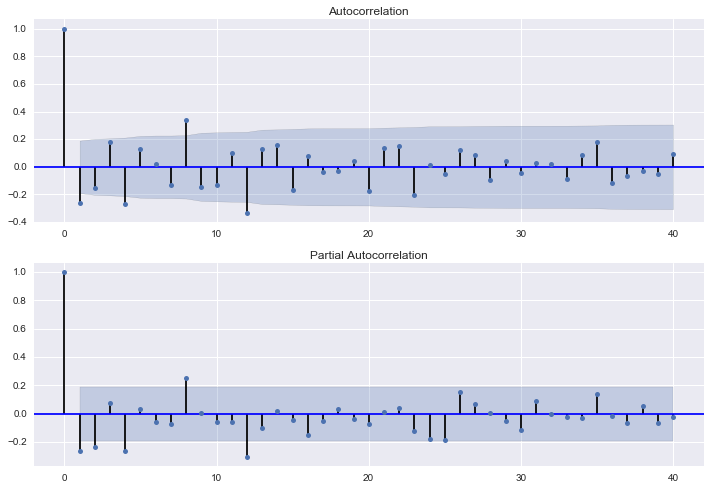

In [10]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(datasets.seasonal_first_difference.iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(datasets.seasonal_first_difference.iloc[13:], lags=40, ax=ax2)

### Bulid Model

In [11]:
mod = sm.tsa.SARIMAX(datasets.Incidence_rate, trend='n', order=(0,1,2), seasonal_order=(0,1,1,12))
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                     Incidence_rate   No. Observations:                  120
Model:             SARIMAX(0, 1, 2)x(0, 1, 1, 12)   Log Likelihood                 -92.813
Date:                            Wed, 24 Aug 2016   AIC                            193.626
Time:                                    14:37:33   BIC                            204.776
Sample:                                01-01-2004   HQIC                           198.154
                                     - 12-01-2013                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3669      0.076     -4.805      0.000      -0.517      -0.217
ma.L2         -0.1333      0.085   

In [12]:
### Plot

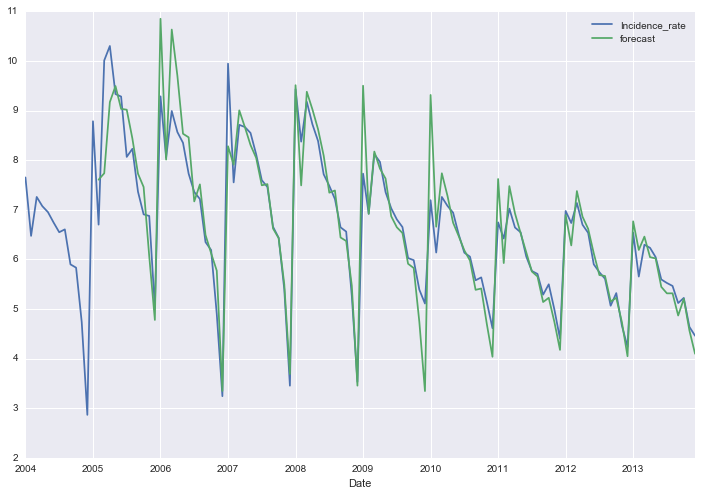

In [13]:
datasets['forecast'] = results.predict(start = 13, end= 131, dynamic= False)  
datasets[['Incidence_rate', 'forecast']].plot(figsize=(12, 8))

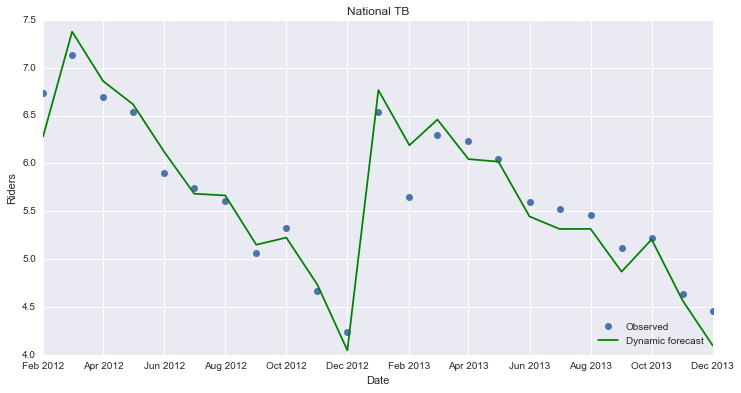

In [14]:
npredict =datasets.Incidence_rate['2004'].shape[0]
fig, ax = plt.subplots(figsize=(12,6))
npre = 12
ax.set(title='National TB', xlabel='Date', ylabel='Riders')
ax.plot(datasets.index[-npredict-npre+1:], datasets.ix[-npredict-npre+1:, 'Incidence_rate'], 'o', label='Observed')
ax.plot(datasets.index[-npredict-npre+1:], datasets.ix[-npredict-npre+1:, 'forecast'], 'g', label='Dynamic forecast')
legend = ax.legend(loc='lower right')
legend.get_frame().set_facecolor('w')

In [17]:
dta = pd.concat([datasets, datasets_pred])[['Death','Death_rate','Incidence','Incidence_rate','forecast','Year','Month']]
dta['forecast'] = results.predict(start=13,end=131,dynamic=False)
dta.tail(13)

,Death,Death_rate,Incidence,Incidence_rate,forecast,Year,Month
Date,,,,,,,
2013-12-01,195,0.014401,60399,4.460651,4.097730,2013,12
2014-01-01,189,0.013947,89128,6.576894,6.741082,2014,1
2014-02-01,178,0.013135,77153,5.693240,6.007863,2014,2
2014-03-01,214,0.015791,84473,6.233394,6.623227,2014,3
2014-04-01,230,0.016972,81543,6.017185,6.426487,2014,4
2014-05-01,212,0.015644,79530,5.868642,6.247385,2014,5
2014-06-01,182,0.013430,76366,5.635166,5.749933,2014,6
2014-07-01,184,0.013578,74607,5.505367,5.615642,2014,7
2014-08-01,188,0.013873,71144,5.249826,5.534096,2014,8


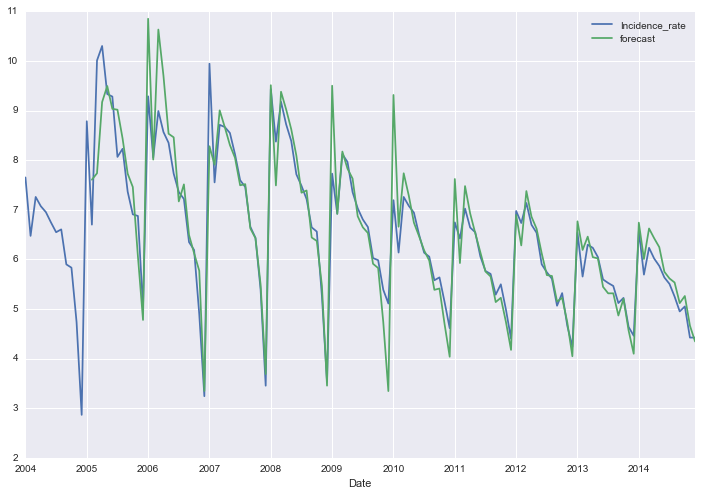

In [18]:
dta['forecast'] = results.predict(start = 13, end= 131, dynamic= False)  
dta[['Incidence_rate','forecast']].plot(figsize=(12, 8))

6.7416819752650206

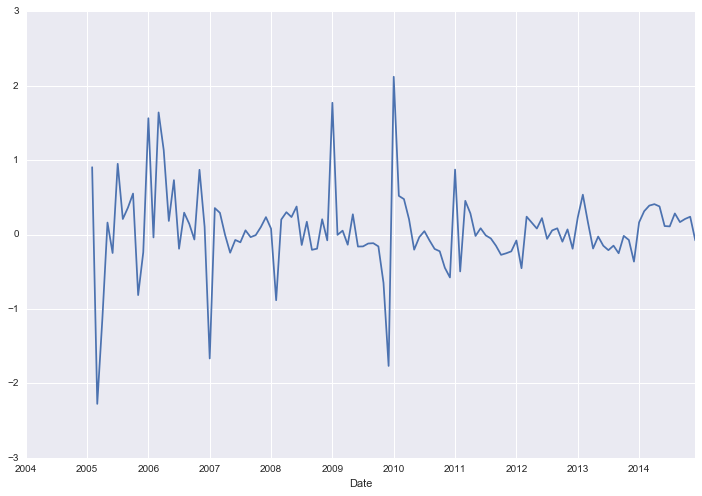

In [19]:
dta['error_ARIMA'] = dta['forecast']-dta['Incidence_rate']
dta['error_ARIMA'] .plot(figsize=(12,8))
sum(dta['error_ARIMA'].dropna())

In [20]:
dta.to_excel('data_SARIMA.xlsx')